In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from SLIP import Image, imread
im = Image(pe='https://raw.githubusercontent.com/bicv/SLIP/master/default_param.py')
help(im)

Help on Image in module SLIP.SLIP object:

class Image(builtins.object)
 |  Image(pe='https://raw.githubusercontent.com/bicv/SLIP/master/default_param.py')
 |  
 |  This library collects different Image Processing tools.
 |  
 |  Fork me on https://github.com/bicv/SLIP !
 |  
 |  This library is used in other projects, in particular  for use with the ``LogGabor`` and ``SparseEdges`` libraries
 |  For more information check respective pages @
 |      - http://pythonhosted.org/LogGabor and
 |      - http://pythonhosted.org/SparseEdges
 |  
 |  Collects image processing routines for one given image size:
 |   - Some classical related to pure Fourier number crunching:
 |      - creating masks
 |      - normalize,
 |      - fourier_grid : defines a useful grid for generating filters in FFT
 |      - show_FT : displays the envelope and impulse response of a filter
 |      - invert : go to the other of the fourier transform
 |  - Some usual application of Fourier filtering:
 |      - trans : 

In [3]:
import os
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
fig_width = 12
figsize=(fig_width, .618*fig_width)
fopts = {'fontsize':18}
opts= {'cmap': plt.cm.gray, 'vmin':-1., 'vmax':1., 'interpolation':'nearest', 'origin':'upper'}

In [4]:
from SLIP import imread

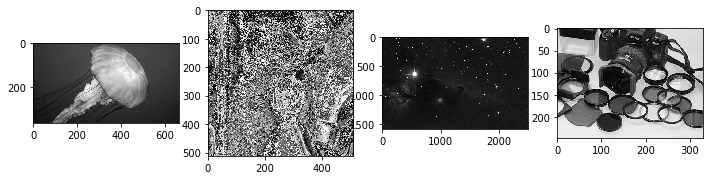

In [5]:
list_images = ['http://static.prsa.pl/images/fad62735-b1c7-4ff4-811e-928b42fa1c89.jpg', 
                            'http://www.cosy.sbg.ac.at/~pmeerw/Watermarking/lena_color.gif', 
                            'https://upload.wikimedia.org/wikipedia/commons/e/e3/The_Horsehead_Nebula_IC434.jpg',
                            'https://upload.wikimedia.org/wikipedia/commons/thumb/a/a3/Filterstef.JPG/330px-Filterstef.JPG']
fig, ax = plt.subplots(1, len(list_images), figsize=figsize)
for i, URL in enumerate(list_images):
    ax[i].imshow(imread(URL), cmap=plt.gray())    


In [6]:
im = Image((128, 128))
help(im.__init__)

Help on method __init__ in module SLIP.SLIP:

__init__(pe='https://raw.githubusercontent.com/bicv/SLIP/master/default_param.py') method of SLIP.SLIP.Image instance
    Initializes the Image class
    
    May take as input:
    
    - a dictionary containing parameters
    - a ``ndarray`` (dimensions ``N_X`` and ``N_Y`` are guessed from this array)
    - a string representing a file or URL pointing to an image file
    - a string pointing to  a file or URL containing a dictionary of parameters (or simply the name of the file)
    - a ``NeuroTools.parameters.ParameterSet`` object containing parameters
    
    Parameters are
    
    - N_X and N_Y which are respectively the number of pixels in the vertical and horizontal dimensions respectively (MANDATORY)
    - optional parameters which are used in the various functions such as N_image when handling a database or the whitening parameters.



In [7]:
#FILTERING
help(im.FTfilter)

Help on method FTfilter in module SLIP.SLIP:

FTfilter(image, FT_filter, full=False) method of SLIP.SLIP.Image instance
    Using the ``FTfilter`` function, it is easy to filter an image with a filter defined in Fourier space.



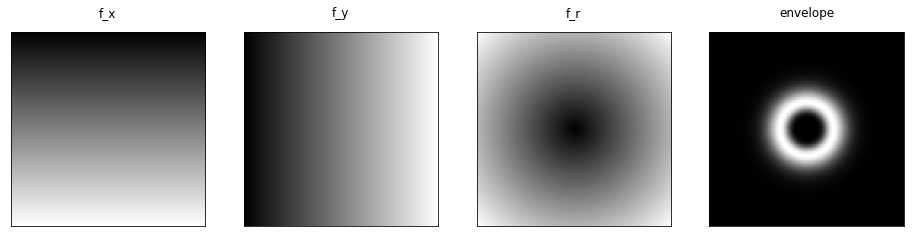

In [18]:
from SLIP import Image
sf_0 = 0.15
B_sf = 0.05
theta_0 = np.pi/2
B_theta = 0.15
loggabor = True

def envelope_radial(im, sf_0=sf_0, B_sf=B_sf, loggabor=loggabor, norm=True):
    if sf_0 == 0.: return 1.
    if loggabor:
        env = 1./im.f*np.exp(-.5*(np.log(im.f/sf_0)**2)/(np.log((sf_0+B_sf)/sf_0)**2))
        if norm: env /= np.sqrt((env**2).sum())
        return env
    else:
        return np.exp(-.5*(im.f - sf_0)**2/B_sf**2)

im = Image(pe='https://raw.githubusercontent.com/bicv/SLIP/master/default_param.py') #Image('default_param.py')
env = envelope_radial(im)

fig, ax = plt.subplots(1, 4, figsize=figsize)
for i, (f, label) in enumerate(zip([im.f_x, im.f_y, im.f, env], ['f_x', 'f_y', 'f_r', 'envelope'])):
    ax[i].matshow(f)
    ax[i].set_title(label)
    ax[i].set_xticks([])
    ax[i].set_yticks([])

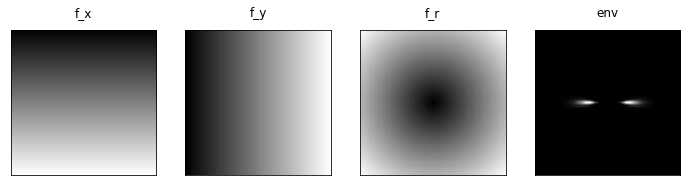

In [9]:
def envelope_orientation(im, theta_0=theta_0, B_theta=B_theta, norm=True):
    env =  np.exp(np.cos(2*(im.f_theta-theta_0))/B_theta**2)
    if norm: env /= np.sqrt((env**2).sum())
    return env


env = envelope_radial(im) * envelope_orientation(im)

fig, ax = plt.subplots(1, 4, figsize=figsize)
for i, (f, label) in enumerate(zip([im.f_x, im.f_y, im.f, env], ['f_x', 'f_y', 'f_r', 'env'])):
    ax[i].matshow(f)
    ax[i].set_title(label)
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    

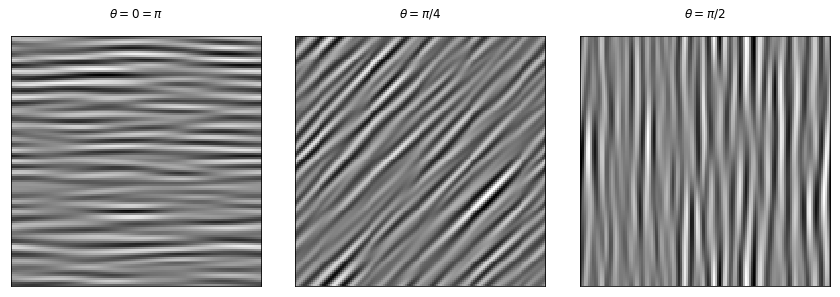

In [10]:
# one can then easily generate a texture
theta0 = np.pi/2
Btheta = 0.15
theta_0 = [0, np.pi/4, np.pi/2]
B_theta = [0.1, 0.5, 1.]

def texture(env):
    return np.fft.fft2(np.fft.ifftshift(env * np.exp(1j * 2 * np.pi * np.random.rand(env.shape[0], env.shape[1])))).real

def impulse(env, phi=2 * np.pi):
    I = np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(env * np.exp(1j * phi))).real)
    I /= env.sum()
    return I

fig, ax = plt.subplots(1, 3, figsize=(fig_width, fig_width*6/18))
for i, (theta0_, label) in enumerate(zip(theta_0, [r'$\theta = 0 = \pi$', r'$\theta = \pi/4$', r'$\theta = \pi/2$']) ) :
    env = envelope_radial(im) * envelope_orientation(im, theta_0=theta0_, B_theta=Btheta)
    I = texture(env)
    ax[i].matshow(I, cmap=plt.cm.gray)
    ax[i].set_title(label)
    ax[i].set_xticks([])
    ax[i].set_yticks([])
plt.tight_layout()

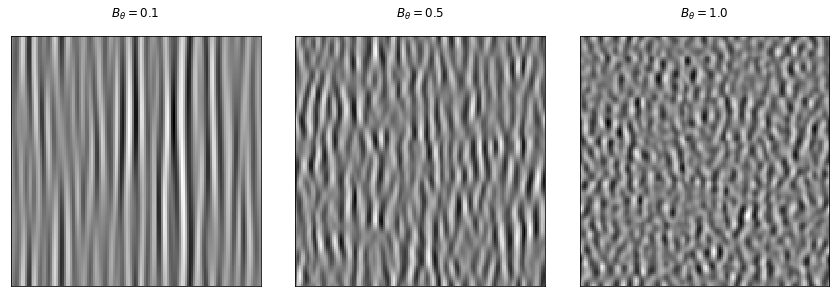

In [11]:
fig, ax = plt.subplots(1, 3, figsize=(fig_width, fig_width*6/18))
for i, (Btheta_, label) in enumerate(zip(B_theta, [r'$B_\theta = 0.1$', r'$B_\theta = 0.5$', r'$B_\theta = 1.0$']) ) :
    env = envelope_radial(im) * envelope_orientation(im, theta_0=theta0, B_theta=Btheta_)
    I = texture(env)
    ax[i].matshow(I, cmap=plt.cm.gray)
    ax[i].set_title(label)
    ax[i].set_xticks([])
    ax[i].set_yticks([])
plt.tight_layout()

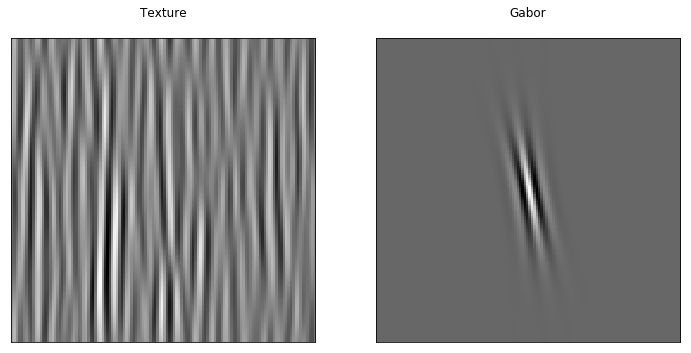

In [12]:
env_in = envelope_radial(im) * envelope_orientation(im)
env_V1 = envelope_radial(im) * envelope_orientation(im, theta_0=np.random.rand()*np.pi)

fig, ax = plt.subplots(1, 2, figsize=figsize)
for i, (f, label) in enumerate(zip([texture(env_in), impulse(env_V1)], [u'Texture', u'Gabor'])):
    ax[i].matshow(f, cmap=plt.cm.gray)
    ax[i].set_title(label)
    ax[i].set_xticks([])
    ax[i].set_yticks([])    

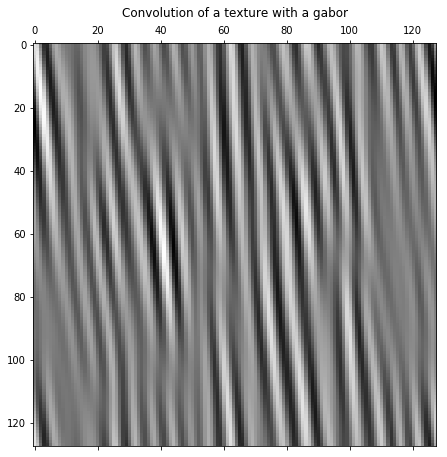

In [13]:
def convolve(image_in, image_V1):
    env_in = np.fft.fft2(image_in)
    env_V1 = np.fft.fft2(image_V1)
    return np.fft.fftshift(np.fft.ifft2((env_in*env_V1)).real)

R = convolve(texture(env_in), impulse(env_V1))
fig, ax = plt.subplots(figsize=figsize)
ax.matshow(R, cmap=plt.cm.gray)
_= plt.title(u"Convolution of a texture with a gabor")

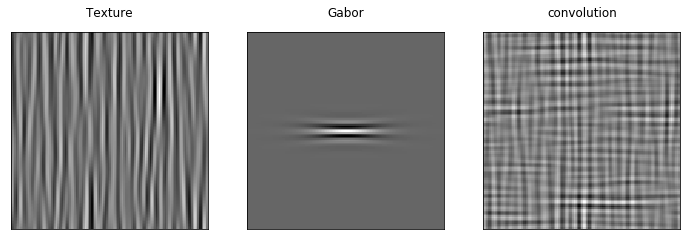

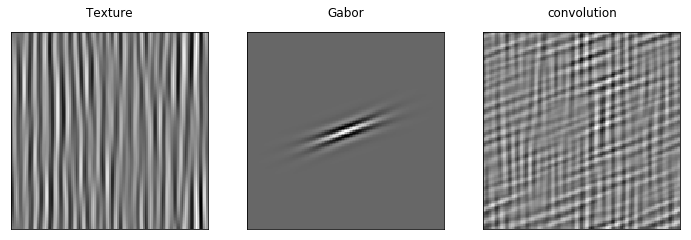

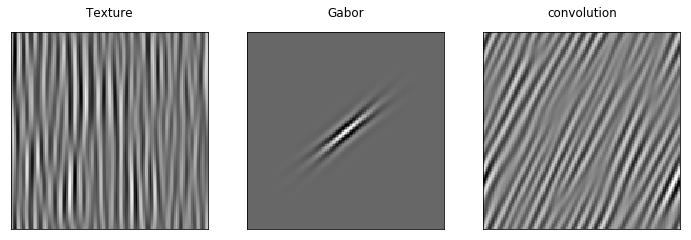

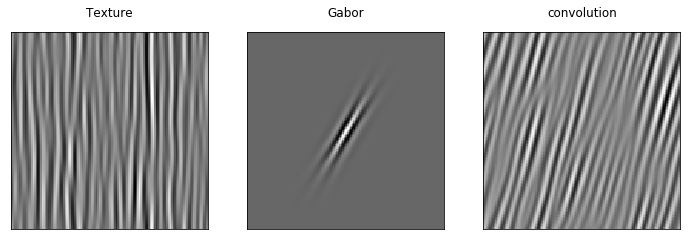

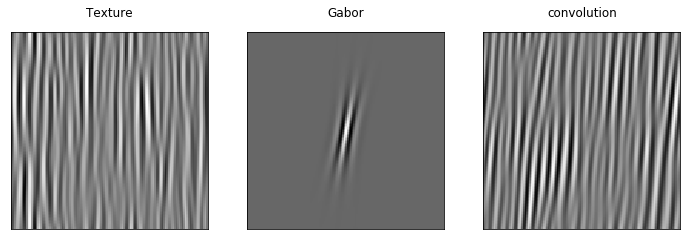

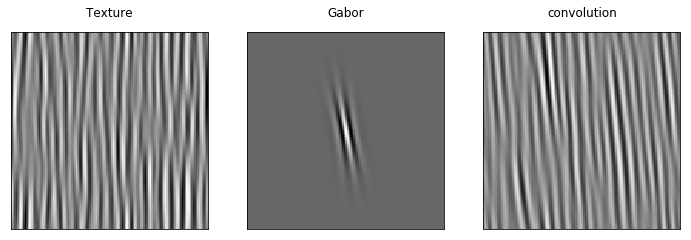

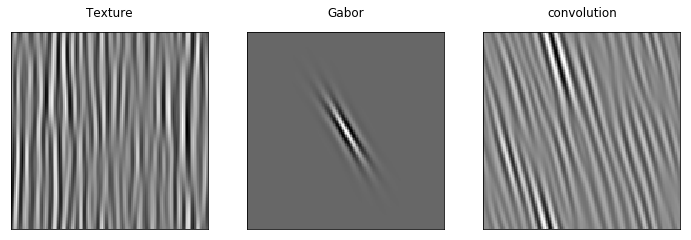

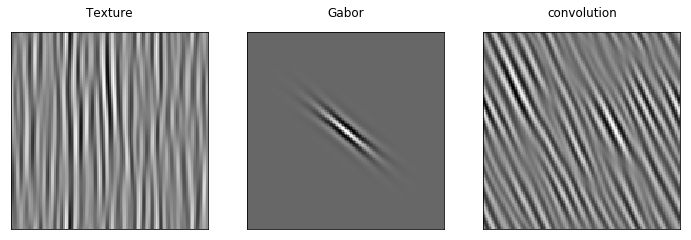

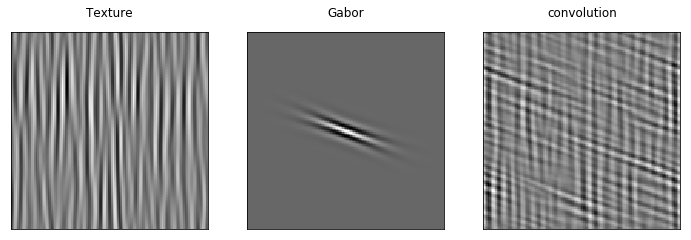

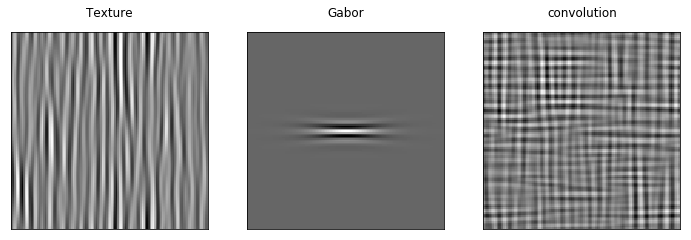

In [14]:
# images of convolutions with differents angles
N_theta=360
theta0 = np.pi/2
theta_0 = np.linspace(0., np.pi, 10)

for i, theta0_ in enumerate(theta_0) :
    env_in = envelope_radial(im) * envelope_orientation(im)
    env_V1 = envelope_radial(im) * envelope_orientation(im, theta_0=theta0_)
    R = convolve(texture(env_in), impulse(env_V1))
    fig, ax = plt.subplots(1, 3, figsize=figsize)
    for i, (f, label) in enumerate(zip([texture(env_in), impulse(env_V1), R], [u'Texture', u'Gabor', u'convolution'])):
        ax[i].matshow(f, cmap=plt.cm.gray)
        ax[i].set_title(label)
        ax[i].set_xticks([])
        ax[i].set_yticks([])

In [15]:
#WHITENING
help(im.whitening_filt)
import os
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
fig_width = 16
figsize=(fig_width, .618*fig_width)
fopts = {'fontsize':18}

Help on method whitening_filt in module SLIP.SLIP:

whitening_filt(recompute=False) method of SLIP.SLIP.Image instance
    Returns the envelope of the whitening filter.
    
    if we chose one based on structural assumptions (``struct=True``)
        then we return a 1/f spectrum based on the assumption that the structure of images
        is self-similar and thus that the Fourier spectrum scales a priori in 1/f.
    
    elif we chose to learn,
        returns theaverage correlation filter in FT space.
    
        Computes the average power spectrum = FT of cross-correlation, the mean decorrelation
        is given for instance by (Attick, 92).
    
    else
        we return the parametrization based on Olshausen, 1996



In [29]:
pe = {'N_image': 100, 'seed': None, 'N_X': 512, 'N_Y': 512, 'noise':
            0.1, 'do_mask': True, 'mask_exponent': 3.0, 'do_whitening': True,
              'white_name_database': 'kodakdb', 'white_n_learning': 0, 'white_N':
                  0.07, 'white_N_0': 0.0, 'white_f_0': 0.4, 'white_alpha': 1.4,
              'white_steepness': 4.0, 'white_recompute': False, 'base_levels':
                  1.618, 'n_theta': 24, 'B_sf': 0.4, 'B_theta': 0.17453277777777776,
              'use_cache': True, 'figpath': 'results', 'edgefigpath':
                  'results/edges', 'matpath': 'cache_dir', 'edgematpath':
                  'cache_dir/edges', 'datapath': 'database/', 'ext': '.pdf', 'figsize':
                  14.0, 'formats': ['pdf', 'png', 'jpg'], 'dpi': 450, 'verbose': 0}

In [32]:
im = Image(pe=pe) 
K = im.whitening_filt()

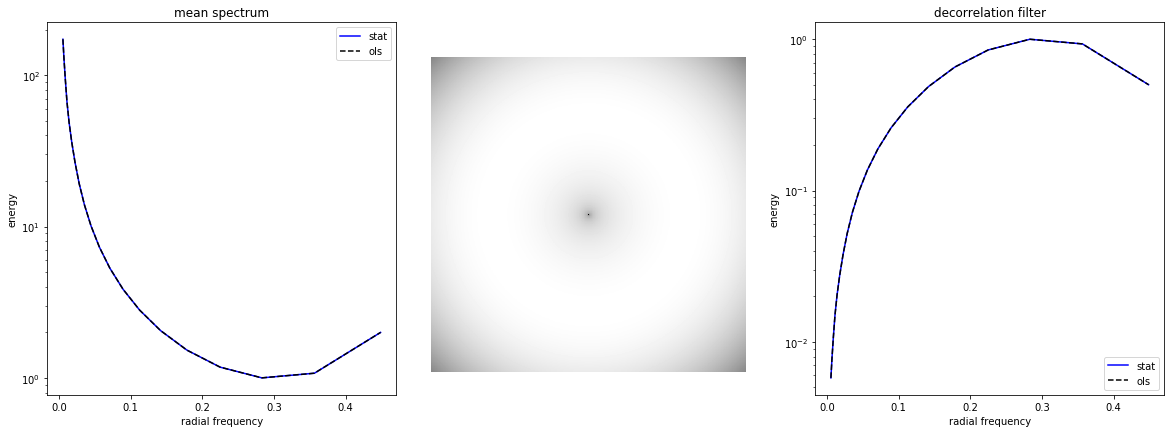

In [33]:
from SLIP import Image
#im = Image('default_param.py')
im = Image(pe=pe) #(pe='https://raw.githubusercontent.com/bicv/SLIP/master/default_param.py')
#im.pe.white_n_learning = 100
K = im.whitening_filt(recompute=True)
f_bins, theta_bins, K_rot = im.hist_radial_frequency(K)
im.pe.white_n_learning = 0
K_ols = im.whitening_filt()
f_bins, theta_bins, K_ols_rot = im.hist_radial_frequency(K_ols)

fig = plt.figure(figsize=(fig_width, fig_width/3))
bord = 0.03
a = plt.axes([bord, bord, 1/3.-bord,  1-bord])
f_bins_m = .5*(f_bins[:-1]+f_bins[1:])
a.semilogy(f_bins_m, 1/K_rot.mean(axis=1),c='b', label='stat')
a.semilogy(f_bins_m, 1/K_ols_rot.mean(axis=1), c='k', ls='--', label='ols')
a.set_xlabel('radial frequency')
a.set_ylabel('energy')
a.set_title('mean spectrum')
a.legend(loc="upper right")

a = plt.axes([1/3.+bord, bord, 1/3.-2*bord , 1. -2*bord])
a.matshow(np.log(K))
a.axis('off')

a = plt.axes([2/3.+bord, bord, 1/3.-bord, 1-bord])
a.semilogy(f_bins_m, K_rot.mean(axis=1),c='b', label='stat')
a.semilogy(f_bins_m, K_ols_rot.mean(axis=1), c='k', ls='--', label='ols')
a.set_xlabel('radial frequency')
a.set_ylabel('energy')
a.set_title('decorrelation filter')
_ = a.legend(loc="lower right")

 Testing that whitening effectively works... 
Figure whitening


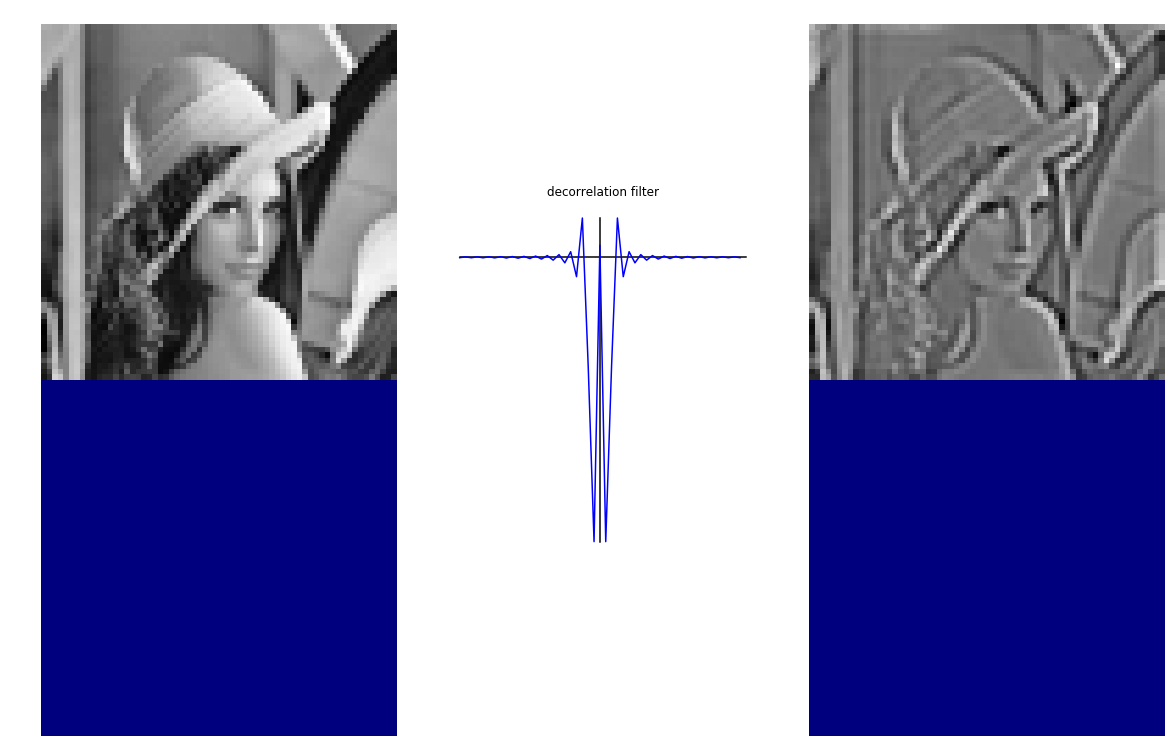

 Testing that whitening effectively works... 
Figure whitening


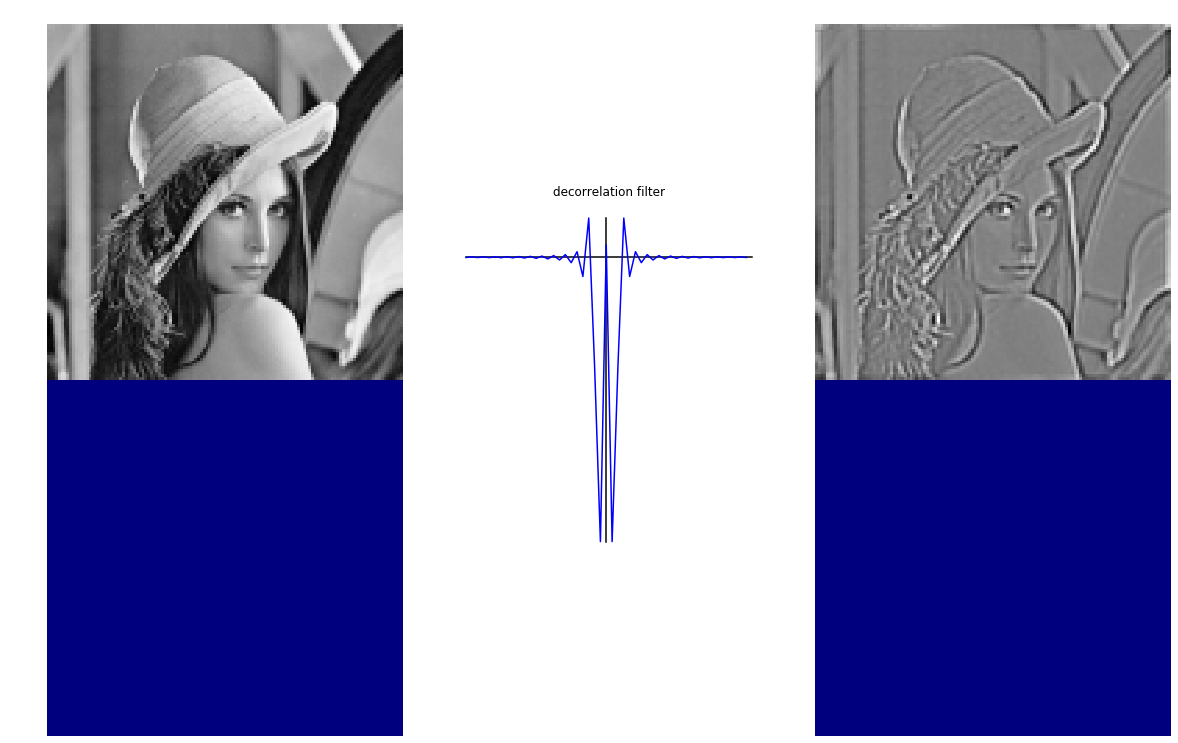

 Testing that whitening effectively works... 
Figure whitening


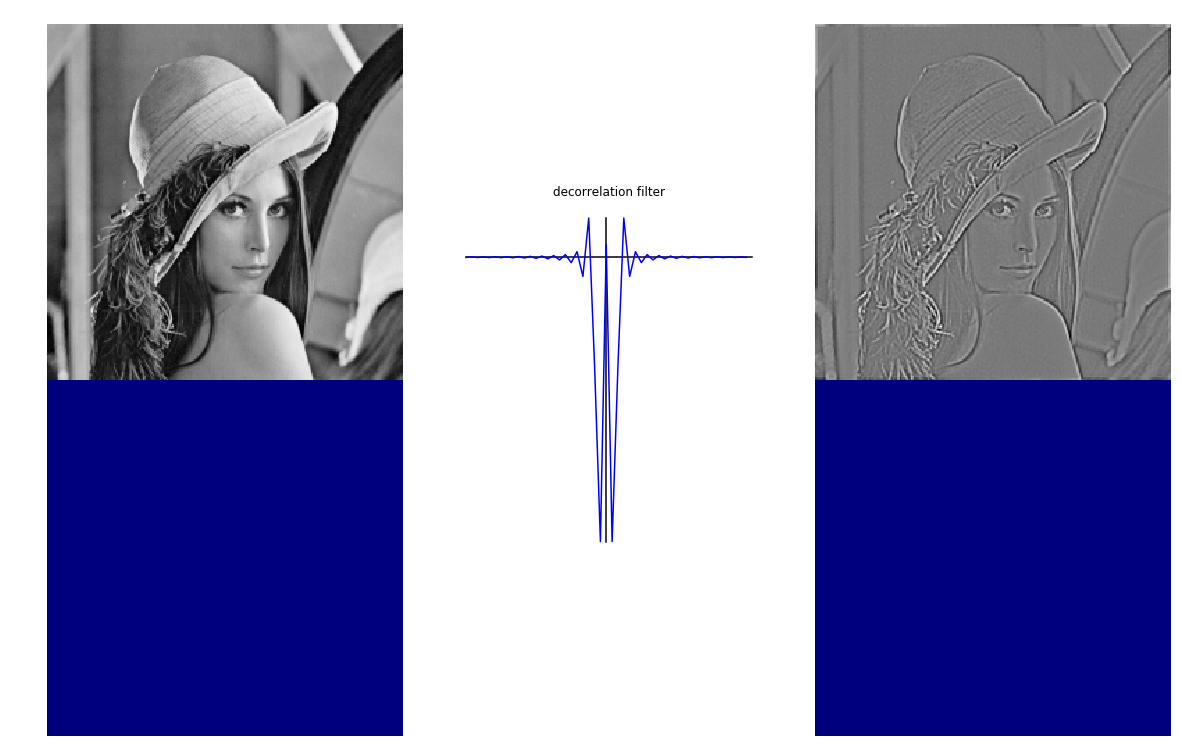

In [36]:
from SLIP import Image
im = Image(pe=pe)

im.pe.white_n_learning = 100
for size in [64, 128, 256]:
    im = Image(pe=pe)
    #im.pe.white_n_learning = 100
    image = im.imread('https://github.com/bicv/SLIP/raw/master/database/lena' + np.str(size) + '.png')
    print(' Testing that whitening effectively works... ')
    xcorr, xcorr_white = np.zeros((im.pe.N_X, im.pe.N_Y)), np.zeros((im.pe.N_X, im.pe.N_Y))
    for i_learning in range(im.pe.white_n_learning):
        image_patch, filename, croparea = im.patch(im.pe.white_name_database, verbose=False)
        xcorr += im.power_spectrum(image_patch)/im.pe.white_n_learning
        image_patch = im.whitening(image_patch)
        xcorr_white += im.power_spectrum(image_patch)/im.pe.white_n_learning

    middle = np.ceil(K.shape[0]/2)
    print('Figure whitening')
    fig = plt.figure(figsize=(fig_width, .618*fig_width))
    bord = .03
    # top left
    a = plt.axes([0,  1/2., 1/3., 1/2.])
    a.matshow(image, cmap=plt.gray())
    a.set_ylabel('image')
    a.axis('off')
    # top right
    a = plt.axes([2/3., 1/2., 1/3., 1/2.])
    white = im.whitening(image)
    a.matshow(white, cmap=plt.gray())
    a.set_ylabel('whitened image')
    a.axis('off')
    # middle
    a = plt.axes([1/3.+bord, .25, 1/3.-2*bord , 1/2.])
    impulse = np.zeros(image.shape)#(25,25))
    impulse[24,24] = 1
    K = im.whitening(impulse)[:49,:49]
    middle = int(np.ceil(K.shape[0]/2))
    K_middle = .5 * (K[middle,:] + K[middle+1,:])
    a.plot([24,24],[np.min(K_middle), np.max(K_middle)], c='k')
    a.plot([0, 49],[0,0], c='k')
    a.plot(K_middle, c='b')
    a.set_title('decorrelation filter')
    a.axis('off')
    # bottom left
    a = plt.axes([0,  0, 1/3., 1/2.])
    a.matshow(xcorr, cmap=plt.jet())#
    a.axis('off')
    #bottom right
    a = plt.axes([2/3., 0, 1/3., 1/2.])
    a.matshow(xcorr_white, cmap=plt.jet())
    a.axis('off')
    plt.show()

<Figure size 432x288 with 0 Axes>

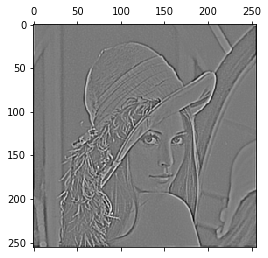

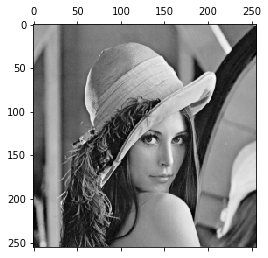

In [41]:
white = im.whitening(image)
plt.matshow(white, cmap=plt.gray())
dewhiten = im.dewhitening(white)
plt.matshow(dewhiten, cmap=plt.gray())


In [37]:
import holoviews as hv
%load_ext holoviews.ipython
%output size=150 dpi=120
%opts Image (cmap='gray')
image = imread('https://github.com/bicv/SLIP/raw/master/database/yelmo512.png')
im.set_size(image)
image = im.preprocess(image)
hv.Image(im.normalize(image), value_dimensions=[hv.Dimension('Image', range=(-1,1))]).hist()

ModuleNotFoundError: No module named 'holoviews'

In [ ]:
#! whitening to balance the energy of evey frequency band
im.pe.white_n_learning = 0
white = im.whitening(image)
hv.Image(im.normalize(white)).hist()

In [ ]:
import imageio
imageio.imsave('database/yelmo512_w.png', white)

In [ ]:
#! the filtering operation preserves infomation (none is lost...)
hv.Image(white - im.FTfilter(white, 1.)).hist()

In [ ]:
""" This is just to remember that we use a simpler fitering technique.

In the Attick LGN, the gain is changed according to an estimation of the SNR.

"""
print('Figure Atick')
image = plt.imread('https://github.com/bicv/LogGabor/raw/master/database/lena256.png')[:,:,0]
im.set_size(image)


contrasts = 1. / 2**np.arange(6)
freqs = np.linspace(0.,.49, 40)
size  = image.shape
x, y = np.mgrid[0:size[0],0:size[1]]

response = np.zeros((len(freqs), len(contrasts)))
for i_contrast, contrast in enumerate(contrasts):
    for i_freq, freq in enumerate(freqs):
        image = contrast * np.sin( 2* np.pi * x * freq)
        white = im.whitening(image)
        response[i_freq,i_contrast] = np.std(white)
response.shape

fig = plt.figure(figsize=(fig_width, 0.618*fig_width))
a = plt.subplot(111)
a.loglog(freqs,response,c='b')
plt.xlabel('frequency (cycles / pixel)')
_ = plt.axis('tight')

In [ ]:
image = plt.imread('https://github.com/bicv/LogGabor/raw/master/database/lena256.png').mean(axis=-1)
print('Mean=', image.mean(), ', std=', image.std())
im = Image('default_param.py')
im.pe.N_X, im.pe.N_Y = image.shape
im.init()
image = im.normalize(image, center=False)
print('Mean=', image.mean(), ', std=', image.std())
image = im.normalize(image, center=True)
print('Mean=', image.mean(), ', std=', image.std())

In [ ]:
fig = plt.figure(figsize=figsize)
a1 = fig.add_subplot(121)
a2 = fig.add_subplot(122)
a1.imshow(im.normalize(image, center=True, use_max=True), **opts)
a1.set_xlabel('Y'), a1.set_ylabel('X')
a1.plot([100.], [50.], 'r*')
a1.text(100., 50., 'X=50., Y=100.')
a1.axis([0, image.shape[0], image.shape[1], 0])
a2.imshow(im.normalize(im.whitening(image), center=True, use_max=True), **opts)
a2.plot([10.], [150.], 'r*')
a2.text(10., 150., 'X=150., Y=10.')
a2.set_xlabel('Y')
v = a2.axis([0, image.shape[0], image.shape[1], 0])

In [ ]:
fig = plt.figure(figsize=figsize)
a1 = fig.add_subplot(121)
a2 = fig.add_subplot(122)
a1.imshow(im.normalize(image, center=True, use_max=True), **opts)
a1.set_xlabel('Y'), a1.set_ylabel('X')
a1.axis([0, image.shape[0], image.shape[1], 0])
a2.imshow(im.normalize(im.dewhitening(im.whitening(image)), center=True, use_max=True), **opts)
a2.set_xlabel('Y')
v = a2.axis([0, image.shape[0], image.shape[1], 0])

In [ ]:
import holoviews as hv
%load_ext holoviews.ipython
%output size=150 dpi=120

In [ ]:
%opts Image (cmap='hot')
key_dims = [hv.Dimension('$f_y$', range=(0, 1)), hv.Dimension('$f_x$', range=(0, 1))]
s_f = hv.Image(im.f, group='radial frequency coordinates', key_dimensions=key_dims).hist()
s_theta = hv.Image(im.f_theta, group='radial frequency coordinates', key_dimensions=key_dims).hist()
s_f + s_theta

In [ ]:
im = Image('default_param.py')
im.pe.datapath = 'database/'
name_database = 'serre07_targets'
imagelist = im.make_imagelist(name_database=name_database)

In [ ]:
F = np.zeros_like(im.f_x)
for filename, croparea in imagelist:
    image, filename_, croparea_ = im.patch(name_database, filename=filename, croparea=croparea, center=False)
    F += np.fft.fftshift(np.absolute(np.fft.fftn(image))**2)
F /= F.max()